# Abstract
Malware classification is a critical aspect of cybersecurity, aiming to identify malicious software by analyzing its structural patterns and behavioral characteristics. Traditional deep learning approaches often rely on automated feature extraction using convolutional neural networks (CNNs) or transformer-based models. However, such methods demand significant computational resources and may struggle with interpretability.

In this project, we explore an alternative strategy—leveraging classic machine learning techniques to classify malware based on its byteplot image representations. Instead of relying on deep feature extraction, we employ well-established statistical learning methods, including Linear Regression, Linear and Quadratic Discriminant Analysis (LDA & QDA), Decision Trees, AdaBoost, Support Vector Machines (SVM), and Gaussian Naïve Bayes. These models process malware binaries transformed into grayscale or RGB images, aiming to capture structural patterns without the overhead of deep learning architectures.

We conduct experiments on multiple publicly available malware datasets, evaluating the effectiveness of classical machine learning classifiers across imbalanced, semi-balanced, and balanced dataset distributions. Performance is measured using accuracy, precision, recall, F1-score, and AUC, allowing for a direct comparison of models. Our findings reveal the strengths and limitations of non-deep learning methods in malware classification and provide insights into their viability as an efficient and interpretable alternative to deep learning. 

# Installing required packages

In [142]:
!pip install split-folders
!pip install seaborn
!pip install networkx
!pip install pandas
!pip install keras
!pip install tensorflow
!pip install tensorflow-addons
!pip install scikit-learn


[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


  Obtaining dependency information for networkx from https://files.pythonhosted.org/packages/b9/54/dd730b32ea14ea797530a4479b2ed46a6fb250f682a9cfb997e968bf0261/networkx-3.4.2-py3-none-any.whl.metadata
  Using cached networkx-3.4.2-py3-none-any.whl.metadata (6.3 kB)
Using cached networkx-3.4.2-py3-none-any.whl (1.7 MB)



[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: Could not find a version that satisfies the requirement tensorflow-addons (from versions: none)
ERROR: No matching distribution found for tensorflow-addons

[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


# Importing the required modules

In [143]:
import random
import os
import copy
import numpy as np
import tensorflow as tf
import re
import configparser
import json
import tempfile

import splitfolders
import keras
import seaborn as sns
import pandas as pd

from typing import Dict, Tuple, List, Union
from pathlib import Path
from hashlib import sha256

from matplotlib import pyplot as plt, image as mpimg
from imblearn.over_sampling import SMOTE
from keras.src.activations import gelu
from keras.src.callbacks import History
from numpy import mean, std
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score, \
    confusion_matrix


DEFAULT_EPOCH = 80

# Suppressing warnings
import warnings
warnings.filterwarnings("ignore")


(*) Using project root: E:\Shared\PenetrationTesting\Git\mcmls


The dataset is already organized into separate directories for training and validation, with images classified by their respective malware types. However, to properly evaluate the models during training, we need to further split the images in the training directory into separate train and test sets. This split ensures that the model can be evaluated on unseen data during the training process, providing a more accurate assessment of its performance.

To achieve this, the class accepts three inputs: the path to the dataset directory, the percentage of images to use for training, and the percentage to reserve for testing.

## Adding utility functions

In [144]:
def snake_to_camel(snake_str):
    return "".join(x.capitalize() for x in snake_str.lower().split("_"))


def camel_to_snake(name):
    name = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', name)
    return re.sub('([a-z0-9])([A-Z])', r'\1_\2', name).lower()


def get_project_root() -> Path:
    return Path(".").absolute().parent.parent


def reorganize_dict(t):
    # Create a new dictionary to store the reorganized data
    new_dict = {}

    # Loop through the outer dictionary (models)
    for model, datasets in t.items():
        # Loop through the inner dictionary (datasets)
        for dataset, value in datasets.items():
            # If the dataset doesn't exist in the new dict, create an entry for it
            if dataset not in new_dict:
                new_dict[dataset] = {}
            # Assign the model and its corresponding value to the new dict under the dataset
            new_dict[dataset][model] = copy.deepcopy(value)

    return new_dict



## Developing logic-wrapping classes

Now, we proceed by developing classes that will help us explore the dataset, uncovering its structure and main characteristics. Moreover, we develop a class for image preprocessing, and finally, one for loading the datasets in memory for training and evaluation.

Firstly, we add the class representing a malware image (byte-plot) dataset (T): `MalwareImages`.

In [145]:
class MalwareImages:
    # A class for loading an image dataset and understanding its class distribution
    # and image samples across classes.

    # Initialize the dataset loader with the dataset path.
    def __init__(self, data_dir: str, n: int):
        self.data_directory = data_dir
        self.class_distribution = dict()
        self.rows = n
        self.columns = n
        self.class_names = []
        self.__get_class_names()

    def __get_class_names(self):
        for malware_type in os.listdir(self.data_directory):
            self.class_names.append(malware_type)
        self.class_names = list(set(self.class_names))

    # Computation of the class distribution of the dataset.
    def __compute_class_distribution(self):
        for malware_type in os.listdir(self.data_directory):
            malware_img_dir = os.path.join(self.data_directory, malware_type)
            self.class_distribution[malware_type] = len(os.listdir(malware_img_dir))

    # Plotting the class distribution.
    def plot_class_distribution(self):
        self.__compute_class_distribution()

        malware_classes = list(self.class_distribution.keys())
        malware_class_frequency = list(self.class_distribution.values())
        color_palette = sns.color_palette("pastel")
        plt.figure(figsize=(8, 8))
        sns.barplot(y=malware_classes,
                    x=malware_class_frequency,
                    palette=color_palette,
                    edgecolor="black",
                    orient='h')
        plt.title("Malware Class Distribution")
        plt.xlabel("Malware Class Frequency")
        plt.ylabel("Malware Type")

    # Insights into samples of different malware images across different classes.
    def malware_samples(self):
        c = 0
        fig, axs = plt.subplots(self.rows, self.columns, figsize=(15, 15))

        for malware_type in os.listdir(self.data_directory):
            malware_img_dir = os.path.join(self.data_directory, malware_type)
            malware_img_sample = random.choice(list(os.listdir(malware_img_dir)))
            malware_img_sample_path = os.path.join(malware_img_dir, malware_img_sample)
            image = mpimg.imread(malware_img_sample_path)
            axs[c // self.columns, c % self.columns].imshow(image, cmap="gray")
            axs[c // self.columns, c % self.columns].set_title(malware_type)
            c += 1

        fig.suptitle("Sample for Malware types")
        plt.subplots_adjust(wspace=0.9)
        plt.show()

Then, we define the Image Processor. The Image processor class will be in charge of pre-processing Malware byte-plots to augment the dataset whenever needed-

In [146]:
# A class to preprocess the malware images to make it usable for training neural networks.
class ImageProcessor:

    # Initialization of the image pre-processor with required file locations.
    def __init__(self, train_dir: str, test_dir: str, val_dir: str, size, colormode: str) -> None:
        self.train_gen = None
        self.test_gen = None
        self.val_gen = None
        self.colormode = colormode
        self.training_data_directory = train_dir
        self.testing_data_directory = test_dir
        self.validation_data_directory = val_dir
        self.size = size
        self.batch_size = 32
        self.seed = 42
        self.class_mode = "categorical"

    # Creating generators based on the preprocessing requirements of the CNN architecture.
    def create_generators(self):
        self.train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
            rescale=1. / 255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True,
        )

        self.test_gen = tf.keras.preprocessing.image.ImageDataGenerator(
            rescale=1. / 255
        )

        self.val_gen = tf.keras.preprocessing.image.ImageDataGenerator(
            rescale=1. / 255
        )

    # Reading the images from the respective directories.
    def get_images(self):
        train_images = self.train_gen.flow_from_directory(
            directory=self.training_data_directory,
            target_size=self.size,
            color_mode=self.colormode,
            class_mode=self.class_mode,
            batch_size=self.batch_size,
            shuffle=True,
            seed=self.seed,
            subset='training',
        )

        val_images = self.val_gen.flow_from_directory(
            directory=self.validation_data_directory,
            target_size=self.size,
            classes=sorted([i for i in os.listdir(self.training_data_directory)]),
            color_mode=self.colormode,
            class_mode=self.class_mode,
            batch_size=self.batch_size,
            shuffle=True,
            seed=self.seed
        )

        test_images = self.test_gen.flow_from_directory(
            directory=self.testing_data_directory,
            target_size=self.size,
            color_mode=self.colormode,
            class_mode=self.class_mode,
            batch_size=self.batch_size,
            shuffle=False,
            seed=self.seed
        )

        return train_images, val_images, test_images

    @staticmethod
    def generator_to_numpy(generator):
        """
        Convert a Keras image generator to numpy arrays of data and labels.

        Args:
            generator: Keras ImageDataGenerator flow instance.

        Returns:
            X (np.ndarray): Flattened image data.
            y (np.ndarray): One-hot encoded labels.
        """
        X, y = [], []
        for batch_x, batch_y in generator:
            X.append(batch_x)
            y.append(batch_y)
            if len(X) * generator.batch_size >= generator.n:
                break
        X = np.vstack(X)  # Combine all batches into one array
        y = np.vstack(y)  # Combine all labels into one array

        y = np.argmax(y, axis=1)  # Convert one-hot labels to class indices

        return X, y

    def get_image_flattened(self):
        train_images, val_images, test_images = self.get_images()

        # Convert train, validation, and test data to numpy arrays
        x_train, y_train = ImageProcessor.generator_to_numpy(train_images)
        x_val, y_val = ImageProcessor.generator_to_numpy(val_images)
        x_test, y_test = ImageProcessor.generator_to_numpy(test_images)

        # Flatten the image data for classical models
        x_train = x_train.reshape(x_train.shape[0], -1)  # Flatten each image
        x_val = x_val.reshape(x_val.shape[0], -1)  # Flatten each image
        x_test = x_test.reshape(x_test.shape[0], -1)  # Flatten each image

        # We also scale the data
        scaler = StandardScaler()
        x_train = scaler.fit_transform(x_train)
        x_val = scaler.transform(x_val)
        x_test = scaler.transform(x_test)

        return x_train, y_train, x_val, y_val, x_test, y_test


Finally, the Dataset loader, which will be used to load the images from the filesystem, provide an API to split them into train/test/validation, etc.

In [147]:
class DatasetLoader:
    def __init__(self):
        # Define data directories using pathlib for OS-independent paths
        self.project_root = get_project_root()
        print(f"(*) Using project root: {self.project_root}")
        config_folder = self.project_root.joinpath("mcmls", "config")
        cf = config_folder.joinpath("config.ini")
        self.config = configparser.ConfigParser(allow_no_value=True, interpolation=configparser.ExtendedInterpolation())
        self.config.read(str(cf))
        self.project_root = self.project_root.joinpath("vitaminc")
        dataset_cf = self.project_root.joinpath(self.config.get("DATASET", "config")).resolve()
        self.dataset_config = {}
        self.training_datasets: Dict[str, MalwareImages] = dict()
        # This seed is l33t
        self.seed = 1337
        with open(str(dataset_cf), "r") as _in:
            datasets = json.load(_in)
            for dataset in datasets.get("datasets"):
                self.dataset_config[dataset.get("name")] = dataset

        self.__base_data_directory = self.project_root.joinpath("data")
        self.__base_split_directory = self.project_root.joinpath("split")

        # Ensure existence
        self.__base_data_directory.mkdir(exist_ok=True)
        self.__base_split_directory.mkdir(exist_ok=True)

    def list_datasets(self) -> List[str]:
        if not self.dataset_config:
            return []
        return [x for x in self.dataset_config.keys()]

    def get_dataset_directory(self, dataset_name: str) -> Path:
        # Dataset directories
        if dataset_name not in self.list_datasets():
            raise ValueError(f"Dataset {dataset_name} not supported")
        return self.__base_data_directory.joinpath(f"{dataset_name}_dataset")

    def get_dataset_image_size(self, dataset_name: str) -> Tuple[int, int]:
        if dataset_name not in self.list_datasets():
            raise ValueError(f"Dataset {dataset_name} not supported")
        w = int(self.dataset_config.get(dataset_name, {}).get("image_size").get("w"))
        h = int(self.dataset_config.get(dataset_name, {}).get("image_size").get("h"))
        return w, h

    def get_dataset_image_colormode(self, dataset_name: str) -> str:
        if dataset_name not in self.list_datasets():
            raise ValueError(f"Dataset {dataset_name} not supported")
        mode = self.dataset_config.get(dataset_name, {}).get("colormode")
        if mode not in ["rgb", "grayscale"]:
            return "rgb"
        return mode

    def get_dataset_class_number(self, dataset_name: str) -> int:
        if dataset_name not in self.list_datasets():
            raise ValueError(f"Dataset {dataset_name} not supported")
        classes = self.dataset_config.get(dataset_name, {}).get("classes")
        return int(classes)

    def get_dataset_class_names(self, dataset_name: str) -> List[str]:
        if dataset_name not in self.list_datasets():
            raise ValueError(f"Dataset {dataset_name} not supported")
        return self.training_datasets.get(dataset_name).class_names

    def get_dataset_options(self, dataset_name: str) -> dict:
        if dataset_name not in self.list_datasets():
            raise ValueError(f"Dataset {dataset_name} not supported")
        options = self.dataset_config.get(dataset_name, {}).get("options")
        return options

    def get_split_directory(self, dataset_name: str) -> Path:
        # Split Dataset directories
        if dataset_name not in self.list_datasets():
            raise ValueError(f"Dataset {dataset_name} not supported")
        return self.__base_split_directory.joinpath(f"{dataset_name}_dataset")

    # Splitting the dataset into training and testing subsets proportionally.
    def __split_dataset(self, src: str, dst: str, train_ratio: float, test_ratio: float):
        splitfolders.ratio(input=src,
                           output=dst,
                           seed=self.seed,
                           ratio=(train_ratio, 0, test_ratio),
                           group_prefix=None,
                           move=False)

    def split_dataset(self, dataset_name: str) -> bool:
        if dataset_name not in self.list_datasets():
            raise ValueError(f"Dataset {dataset_name} not supported")
        train_d = self.get_dataset_directory(dataset_name).joinpath("train")
        new_train_test_d = self.get_split_directory(dataset_name)
        # Ensure the split doesn't exist yet
        if not new_train_test_d.is_dir():
            self.__split_dataset(str(train_d), str(new_train_test_d), 0.8, 0.2)

        # Cheating: just check for the directories to exist
        return self.get_training_data_dir(dataset_name).is_dir() and self.get_testing_data_dir(dataset_name).is_dir()

    def get_training_data_dir(self, dataset_name: str, split: bool = True) -> Path:
        if split:
            return self.get_split_directory(dataset_name).joinpath("train")
        return self.get_dataset_directory(dataset_name).joinpath("train")

    def get_validation_data_dir(self, dataset_name: str) -> Path:
        return self.get_dataset_directory(dataset_name).joinpath("val")

    def get_testing_data_dir(self, dataset_name: str) -> Path:
        return self.get_split_directory(dataset_name).joinpath("test")

    def split_all_dataset(self) -> bool:
        success = []
        for dataset_name in self.list_datasets():
            print(f"(*) Splitting dataset {dataset_name} in Train / Test / Validate")
            success.append(self.split_dataset(dataset_name))
        return all(success)

    def load_dataset(self, dataset_name: str, split: bool):
        if dataset_name not in self.list_datasets():
            raise ValueError(f"Dataset {dataset_name} not supported")
        self.training_datasets[dataset_name] = MalwareImages(
            data_dir=str(self.get_training_data_dir(dataset_name, split=split)),
            n=int(self.dataset_config.get(dataset_name, {}).get("d"))
        )

    def load_datasets(self, split: bool):
        for dataset_name in self.list_datasets():
            self.load_dataset(dataset_name, split=split)

    def plot_datasets(self):
        for dataset_name in self.list_datasets():
            self.plot_dataset(dataset_name)

    def plot_dataset(self, dataset_name: str):
        if dataset_name not in self.list_datasets():
            raise ValueError(f"Dataset {dataset_name} not supported")
        dataset = self.training_datasets.get(dataset_name)
        if dataset is not None:
            dataset.plot_class_distribution()
            dataset.malware_samples()
        else:
            print(f"[-] Dataset {dataset_name} not loaded")


# Dataset Exploration

At this point, we can easily explore the dataset to understand its structure and characteristics, by using the previously implemented class. 

## List datasets

In [148]:
loader = DatasetLoader()
loader.list_datasets()
loader.load_datasets(split=True)

(*) Using project root: C:\Dev


## Malimg Dataset

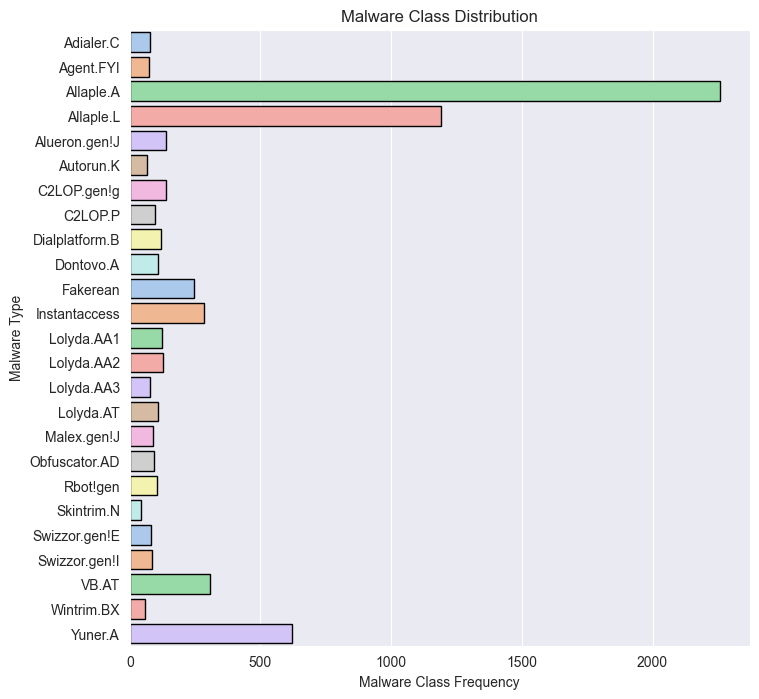

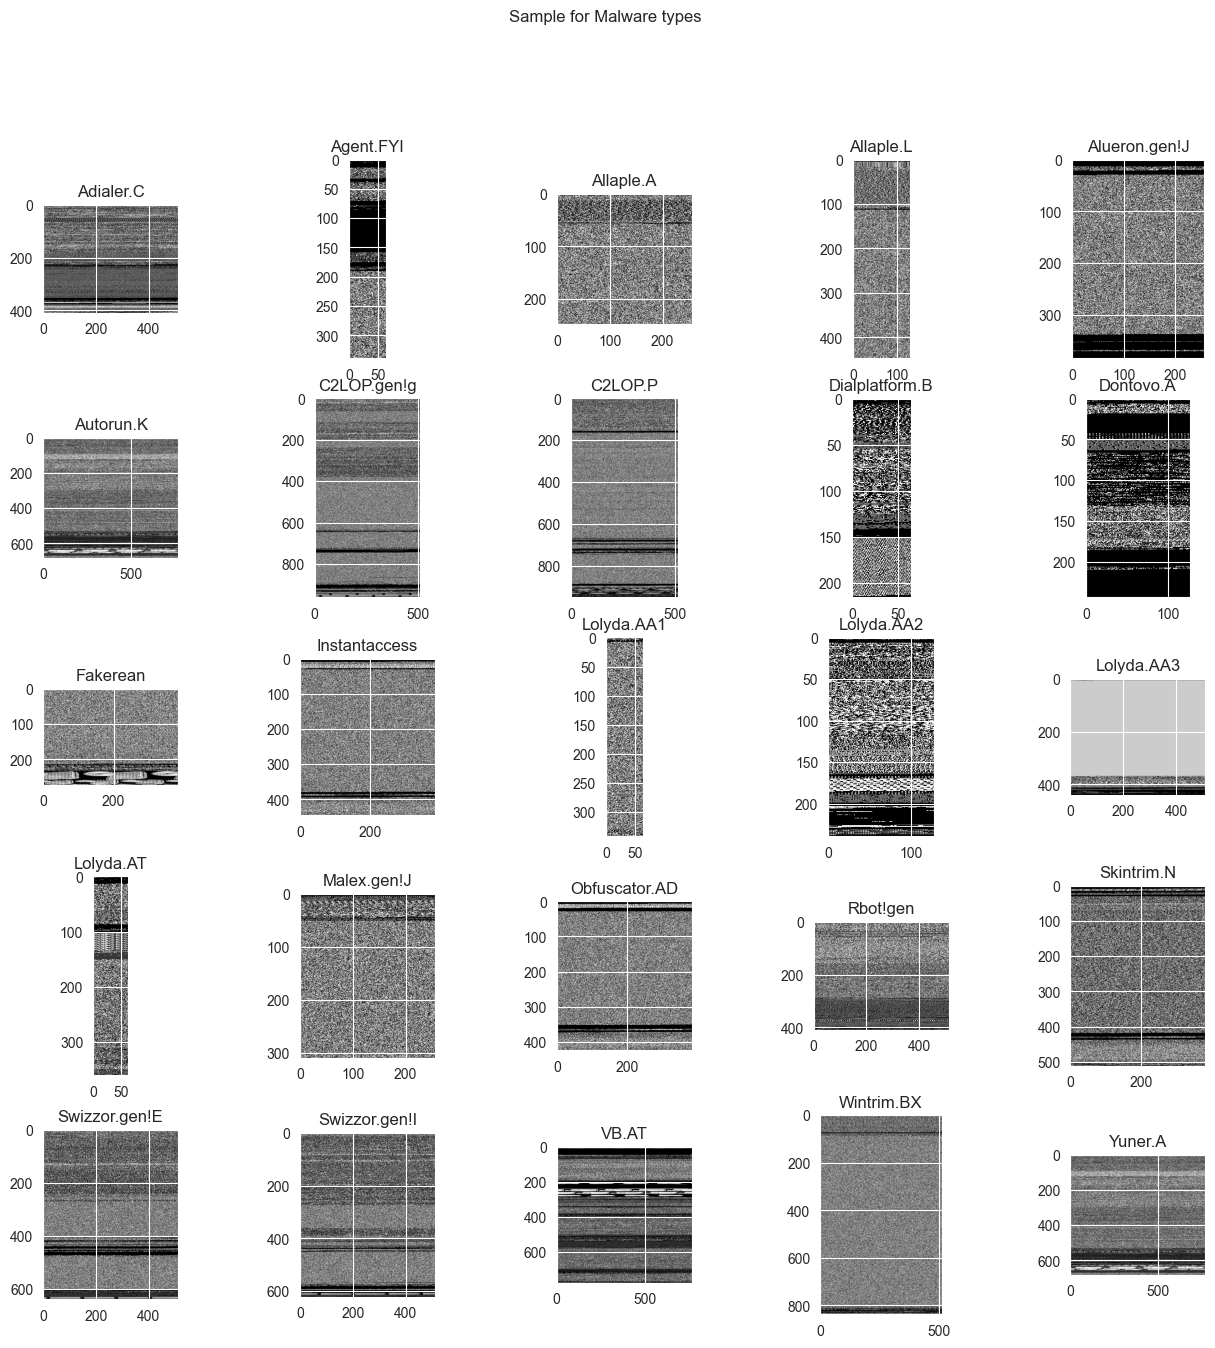

In [149]:
loader.plot_dataset("malimg")

Several key considerations could be inferred from the class distribution:

1. The dataset appears to be highly **imbalanced**. For example, classes like **Allaple.A** and **Allaple.L** have significantly more samples compared to other malware types. These two classes dominate the dataset, with frequencies exceeding 2000 samples, whereas many other classes have fewer than 100 samples.
   
2. There is a long tail in the distribution where many classes have very few samples. Classes such as **Agent.FYI**, **C2LOP.P**, **Malex.gen!J**, and **VB.AT** have very few instances, indicating that these classes might contribute minimally to the overall dataset in terms of sample size.

3. Models trained on imbalanced data tend to be biased towards the majority classes (in this case, **Allaple.A** and **Allaple.L**), potentially leading to poor performance on minority classes. The model may have high overall accuracy but will likely perform poorly in distinguishing between less frequent classes.

## Malevis Dataset

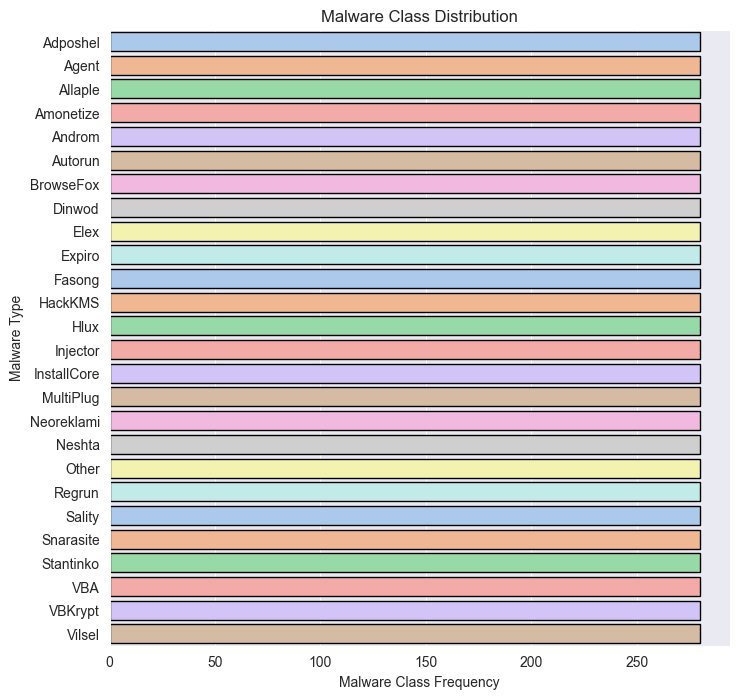

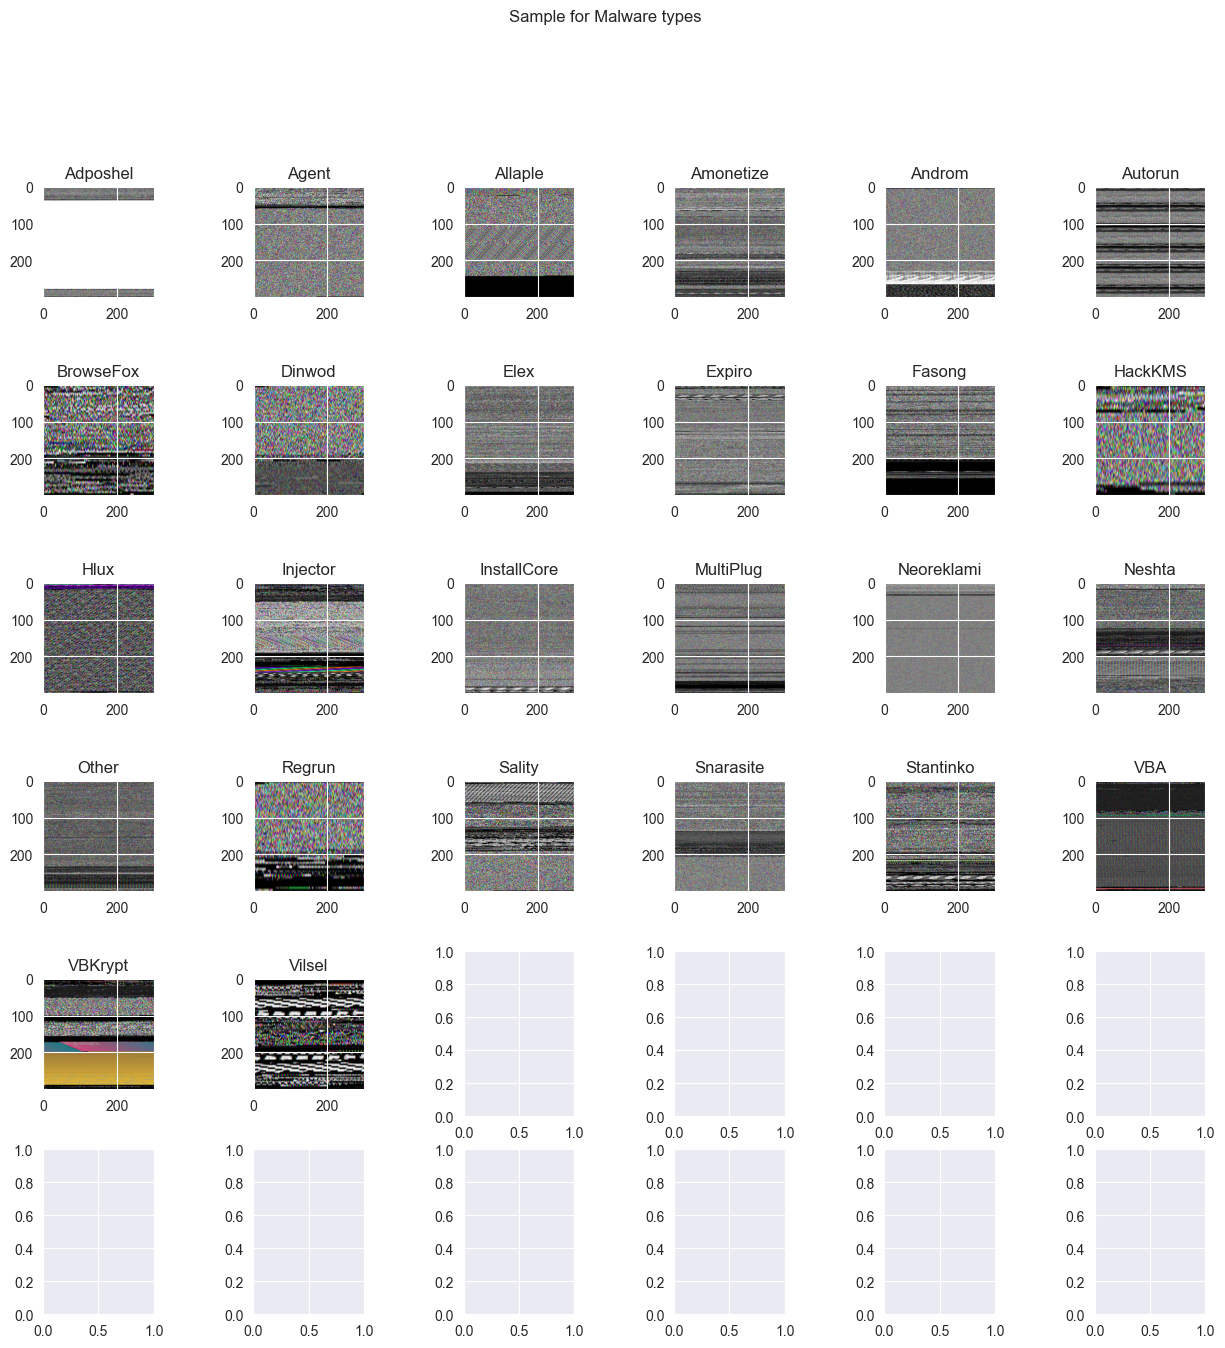

In [150]:
loader.plot_dataset("malevis")

Unlike the first dataset, the malware classes in this distribution are fairly uniform, with each class having roughly the same number of samples (approximately 300 to 350 samples per class).

## Blended Dataset

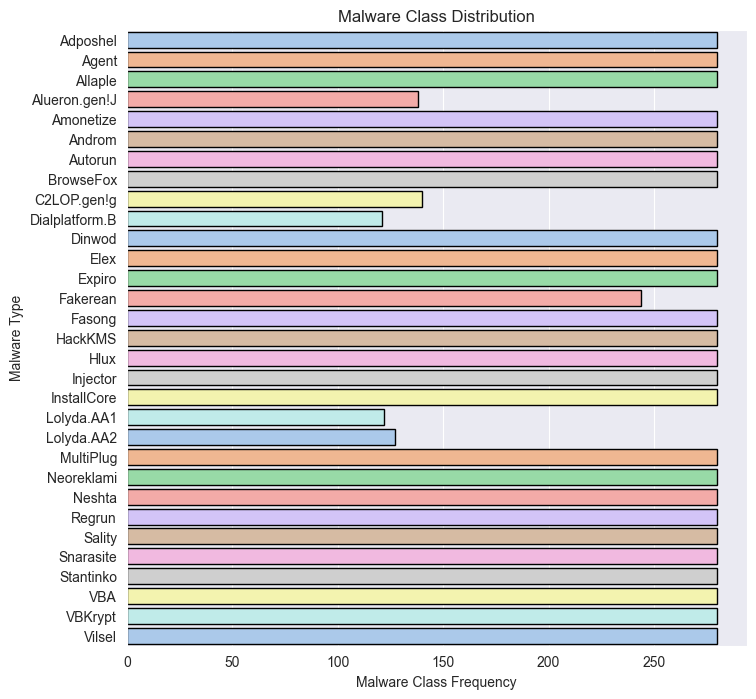

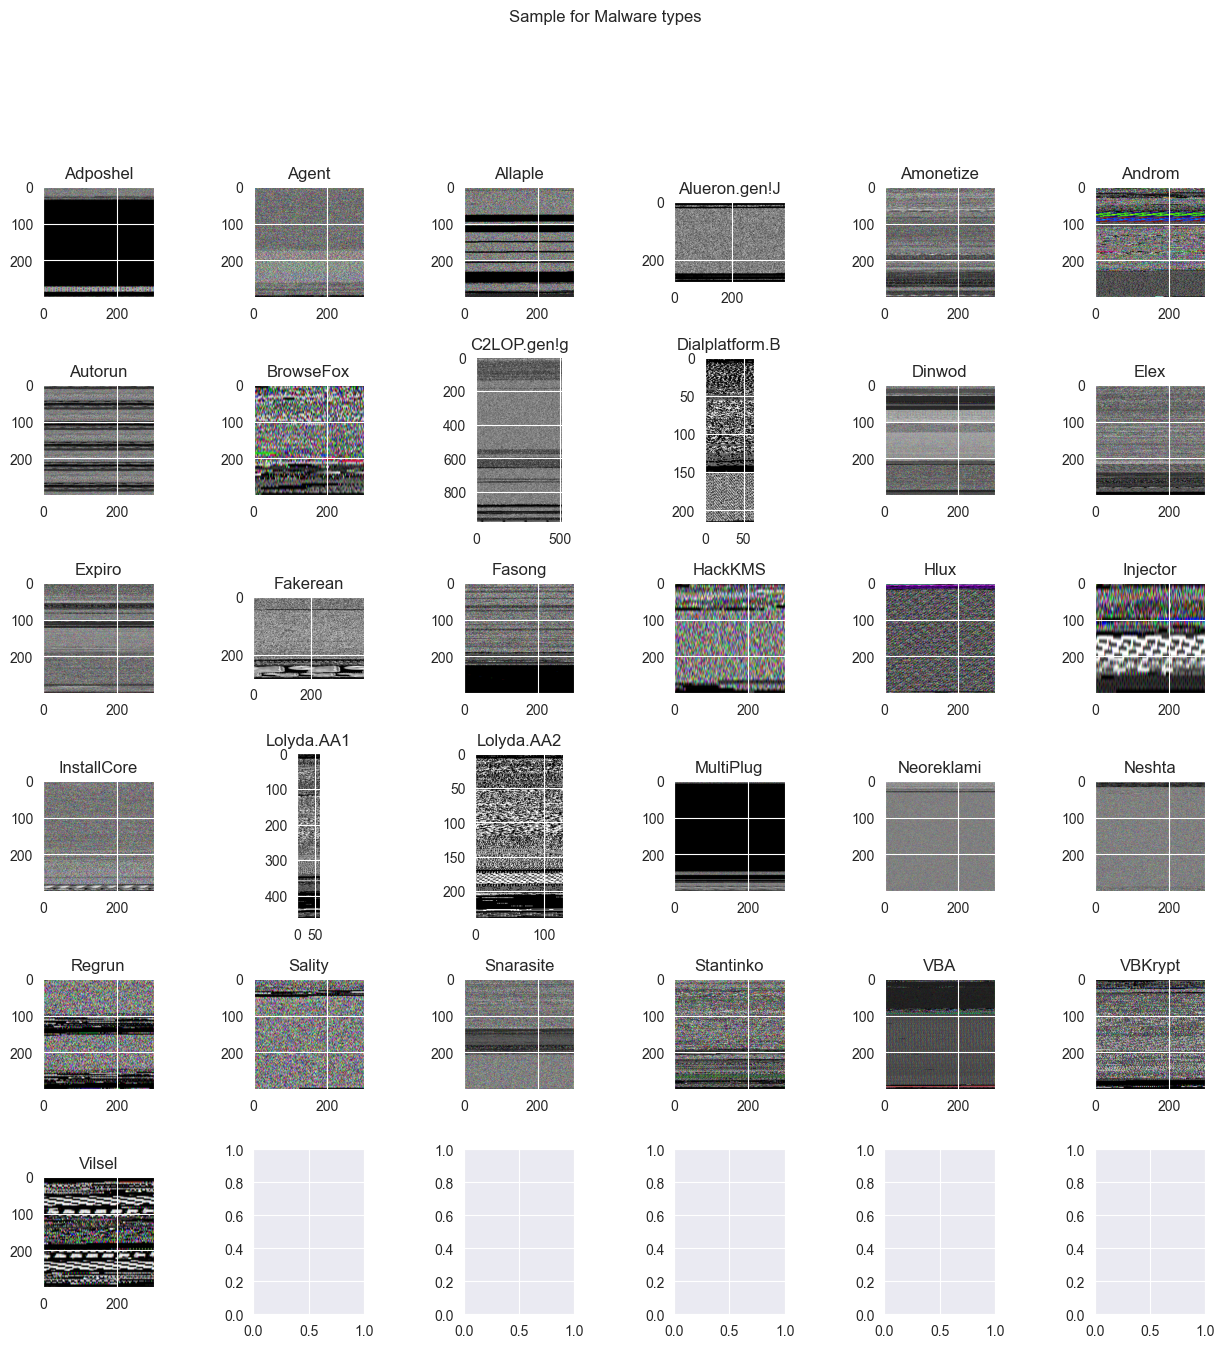

In [151]:
loader.plot_dataset("blended")

The blended dataset, as expected being a combination of the previous two datasets, has a semi-balanced class distribution, with most malware types having similar numbers of samples, but with a few minority classes that are under-represented.

# Model Implementation

Now, to simplify the creation of the models that we want to compare, we provide an abstract interface that wraps common logic for models that are provided by the scikit-learn package. In this way, implementing and evaluating several different models should be trivial.

In [152]:
from abc import ABC, abstractmethod

class IModel(ABC):

    def __init__(self, **kwargs) -> None:
        self.checkpoint_filepath = tempfile.NamedTemporaryFile(delete=False, suffix=".weights.h5").name
        self.kwargs = kwargs
        self.train = self.kwargs.pop("training", None)  # Remove DirectoryIterator because it can't be serialized
        self.val = kwargs.get("validation")
        self.history = None
        self.number_of_classes = kwargs.get("number_of_classes")
        self.regularize = kwargs.get("regularize", False)
        self.patience = kwargs.get("patience", 10)
        self.num_epoch = kwargs.get("num_epoch", DEFAULT_EPOCH)
        self.learning_rate = kwargs.get("learning_rate", 0.001)
        self.weight_decay = kwargs.get("weight_decay", 0.0001)
        self.activation = kwargs.get("activation", gelu)
        self.input_shape = kwargs.get("input_shape")
        self.batch_size = 32
        self.callbacks = []

        # Because we all know the ultimate answer is 42
        self.random_state = 42

        # Params really needed in classic learning
        self.solver = kwargs.get("solver")
        self.n_jobs = kwargs.get("n_jobs", -1)
        self.multi_class = kwargs.get("multi_class")
        self.cv = kwargs.get("cv", RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1))

        # Inner model supported by scikit
        self.model = None

    def load_kwargs(self, **kwargs):
        self.kwargs = kwargs
        self.train = kwargs.get("training")
        self.val = kwargs.get("validation")
        self.number_of_classes = kwargs.get("number_of_classes")
        self.regularize = kwargs.get("regularize", False)
        self.patience = kwargs.get("patience", 10)
        self.num_epoch = kwargs.get("num_epoch", DEFAULT_EPOCH)
        self.learning_rate = kwargs.get("learning_rate", 0.001)
        self.weight_decay = kwargs.get("weight_decay", 0.0001)
        self.activation = kwargs.get("activation", gelu)
        self.input_shape = kwargs.get("input_shape")

    def enable_checkpoint(self):
        checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
            self.checkpoint_filepath,
            monitor="val_accuracy",
            save_best_only=True,
            save_weights_only=True,
        )
        self.callbacks.append(checkpoint_callback)

    def evaluate(self, X, y):
        # evaluate the model and collect the scores
        n_scores = cross_val_score(self.model, X, y, scoring='accuracy', cv=self.cv, n_jobs=self.n_jobs)
        # report the model performance
        print('Mean Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

    def search_best_cv(self, X, y, solvers: list = None):
        if solvers is None or len(solvers) == 0:
            return
        grid = dict()
        grid['solver'] = solvers
        # define search
        search = GridSearchCV(self.model, grid, scoring='accuracy', cv=self.cv, n_jobs=self.n_jobs)
        # perform the search
        results = search.fit(X, y)
        # summarize
        print('Mean Accuracy: %.3f' % results.best_score_)
        print('Config: %s' % results.best_params_)

    @abstractmethod
    def create_model(self, preprocess=True):
        pass

    # Training the model with Early Stopping Criterion
    # on Validation Loss.
    def fit(self, X, y):
        self.model.fit(X, y)

    def smote(self, x_train, y_train) -> tuple:
        smote = SMOTE(random_state=self.random_state)
        x_train_balanced, y_train_balanced = smote.fit_resample(x_train, y_train)
        return x_train_balanced, y_train_balanced

    def predict(self, X):
        return self.model.predict(X)

    def save_inner_model(self, path: Path):
        self.model.save(str(path))

    def load_inner_model(self, path: Path):
        self.model = keras.models.load_model(str(path))

    def save_parameters(self, path: Path):
        with open(str(path), "w") as f:
            json.dump(self.kwargs.__dict__, f)

    def load_parameters(self, path: Path):
        with open(str(path), "r") as f:
            kwargs = json.load(f)
        self.load_kwargs(**kwargs)

    def save_history(self, path: Path):
        with open(str(path), "w") as f:
            json.dump(self.history.history, f)

    def load_history(self, path: Path):
        with open(str(path), "r") as f:
            self.history = History()
            self.history.history = json.load(f)

    # This function should be used to identify specific constructions of the ViT
    def hashed_params(self):
        return sha256(json.dumps(self.kwargs, sort_keys=True).encode('utf8')).hexdigest()


Then, we provide a factory to instantiate a specific model by its code name.

In [153]:
import importlib

class ModelFactory:
    @staticmethod
    def from_name(name: str, **kwargs) -> Union[IModel, None]:
        try:
            _class_name = name
            _class = eval(f"{_class_name}Model")
            return _class(**kwargs)
        except Exception as e:
            import traceback
            traceback.print_exc()
            return None

    @staticmethod
    def list_all():
        models = [
            "lr", "lda", "qda", "dtc", "svm", "ab", "gnb"
        ]
        return [snake_to_camel(m) for m in models]

Finally, we start implementing the various models to compare. The models that we include in this comparison, are:
- Logistic Regression
- Linear Discriminant Analysis (LDA)
- Quadratic Discriminant Analysis (QDA)
- Decision Trees
- AdaBoost
- Support Vector Machine (SVM)
- Gaussian Naïve Bayes

In [154]:
from sklearn.linear_model import LogisticRegression


class LrModel(IModel):
    def __init__(self):
        kwargs = {
            "multi_class": "multinomial",
            "solver": "lbfgs"
        }
        super().__init__(**kwargs)
        self.name = "Logistic Regression"

    def create_model(self, preprocess=False):
        self.model = LogisticRegression(multi_class=self.multi_class, solver=self.solver)


In [155]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


class LdaModel(IModel):
    def __init__(self):
        kwargs = {
            "multi_class": "multinomial",
            "solver": "svd"
        }
        super().__init__(**kwargs)
        self.name = "Linear Discriminant Analysis"

    def create_model(self, preprocess=False):
        self.model = LinearDiscriminantAnalysis(solver=self.solver)


In [156]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis


class QdaModel(IModel):
    def __init__(self):
        kwargs = {
        }
        super().__init__(**kwargs)
        self.name = "Quadratic Discriminant Analysis"

    def create_model(self, preprocess=False):
        self.model = QuadraticDiscriminantAnalysis()


In [157]:
from sklearn.tree import DecisionTreeClassifier


class DtcModel(IModel):
    def __init__(self):
        kwargs = {
            "criterion": "gini",
            "splitter": "best"
        }
        super().__init__(**kwargs)
        self.name = "Decision Tree Classifier"

    def create_model(self, preprocess=False):
        self.model = DecisionTreeClassifier(**self.kwargs)


In [158]:
from sklearn.svm import SVC


class SvcModel(IModel):
    def __init__(self):
        kwargs = {
            "kernel": "rbf",
            "C": 1.0,
            "gamma": "scale"
        }
        super().__init__(**kwargs)
        self.name = "Support Vector Classifier"

    def create_model(self, preprocess=False):
        self.model = SVC(**self.kwargs)

In [159]:
from sklearn.ensemble import AdaBoostClassifier


class AbModel(IModel):
    def __init__(self):
        kwargs = {
            "n_estimators": 50,
            "learning_rate": 1.0
        }
        super().__init__(**kwargs)
        self.name = "AdaBoost Classifier"

    def create_model(self, preprocess=False):
        self.model = AdaBoostClassifier(**self.kwargs)


In [160]:
from sklearn.naive_bayes import GaussianNB


class GnbModel(IModel):
    def __init__(self):
        kwargs = {}
        super().__init__(**kwargs)
        self.name = "Gaussian Naive Bayes"

    def create_model(self, preprocess=False):
        self.model = GaussianNB()


Once the models have been developed, we can create a full classifier, which will wrap the training, evaluation, and comparison logic of all the models previously implemented.  

In [161]:
import json
from pathlib import Path

import pandas as pd
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score, \
    confusion_matrix
from typing import List, Dict

from core.dataloader import DatasetLoader
from core.processor import ImageProcessor
from factory.models import ModelFactory
import seaborn as sns


class McMls:
    def __init__(self, results_dir: str):
        """
        Initialize the pipeline.

        Args:
            results_dir: Path to store results.
        """
        self.loader: DatasetLoader = DatasetLoader()
        self.results_directory = Path(self.loader.config.get("GLOBAL", "results"))
        self.results_directory.mkdir(exist_ok=True)
        self.test_data = {dataset: {} for dataset in self.loader.list_datasets()}
        self.mc = None
        self.dmc = None
        self.__supported_models: List[str] = ModelFactory.list_all()

        self.results_dir = Path(results_dir)
        self.results_dir.mkdir(parents=True, exist_ok=True)

        self.results = {dataset: {} for dataset in self.loader.list_datasets()}

    def list_models(self) -> List[str]:
        """Return a list of supported models."""
        return list(self.__supported_models)

    def preprocess_dataset(self, dataset_name: str):
        """
        Preprocess a dataset using the ImageProcessor class.

        Args:
            dataset_name: Name of the dataset to preprocess.

        Returns:
            Tuple of flattened train, validation, and test data.
        """
        image_flat_size = self.loader.get_dataset_image_size(dataset_name)
        color_mode = self.loader.get_dataset_image_colormode(dataset_name)

        # Preprocessing the images.
        preprocessor = ImageProcessor(
            str(self.loader.get_training_data_dir(dataset_name, split=True)),
            str(self.loader.get_testing_data_dir(dataset_name)),
            str(self.loader.get_validation_data_dir(dataset_name)),
            image_flat_size,
            color_mode
        )
        preprocessor.create_generators()

        # Get flattened data
        return preprocessor.get_image_flattened()

    def train_and_evaluate(self, model_name: str, dataset_name: str):
        """
        Train and evaluate a model on the given dataset.

        Args:
            model_name: Name of the model to train.
            dataset_name: Name of the dataset to use.
        """
        # Preprocess dataset
        x_train, y_train, x_val, y_val, x_test, y_test = self.preprocess_dataset(dataset_name)

        # Initialize and train the model
        model = ModelFactory.from_name(model_name)
        model.create_model()

        # We try to balance it
        x_train, y_train = model.smote(x_train, y_train)

        model.fit(x_train, y_train)

        val_predictions = model.predict(x_val)
        test_predictions = model.predict(x_test)

        # Compute validation metrics
        val_accuracy = accuracy_score(y_val, val_predictions)
        val_precision = precision_score(y_val, val_predictions, average="weighted", zero_division=1)
        val_recall = recall_score(y_val, val_predictions, average="weighted", zero_division=1)
        val_f1 = f1_score(y_val, val_predictions, average="weighted", zero_division=1)

        # Compute test metrics
        test_accuracy = accuracy_score(y_test, test_predictions)
        test_precision = precision_score(y_test, test_predictions, average="weighted", zero_division=1)
        test_recall = recall_score(y_test, test_predictions, average="weighted", zero_division=1)
        test_f1 = f1_score(y_test, test_predictions, average="weighted", zero_division=1)

        # Classification report
        report = classification_report(y_test, test_predictions, output_dict=True, zero_division=1)

        # Confusion matrix
        conf_matrix = confusion_matrix(y_test, test_predictions)

        # Save results
        self.results[dataset_name][model_name] = {
            "validation_metrics": {
                "accuracy": val_accuracy,
                "precision": val_precision,
                "recall": val_recall,
                "f1_score": val_f1,
            },
            "test_metrics": {
                "accuracy": test_accuracy,
                "precision": test_precision,
                "recall": test_recall,
                "f1_score": test_f1,
            },
            "classification_report": report,
            "confusion_matrix": conf_matrix.tolist(),  # Convert to list for JSON serialization
        }

    def evaluate_all_models(self):
        """Evaluate all models on all datasets."""
        for model_name in self.list_models():
            self.evaluate_model(model_name)

    def evaluate_model(self, model_name):
        for dataset in self.loader.list_datasets():
            try:
                print(f"Training {model_name} on {dataset}...")
                self.train_and_evaluate(model_name, dataset)
            except Exception as e:
                print(f"Exception occurred training {model_name} on {dataset}: {e}")

    def evaluate_subset(self, model_names: list, dataset_names: list):
        for model_name in model_names:
            for dataset_name in dataset_names:
                try:
                    print(f"Training {model_name} on {dataset_name}...")
                    self.train_and_evaluate(model_name, dataset_name)
                except Exception as e:
                    print(f"Exception occurred training {model_name} on {dataset_name}: {e}")

    def save_results(self):
        """Save all evaluation results as JSON."""
        for dataset, dataset_results in self.results.items():
            dataset_dir = self.results_dir.joinpath(dataset)
            dataset_dir.mkdir(parents=True, exist_ok=True)

            for model_name, model_results in dataset_results.items():
                model_path = dataset_dir.joinpath(f"{model_name}_results.json")
                with open(model_path, "w") as f:
                    json.dump(model_results, f)

    def load_results(self):
        """Load previously saved results into memory."""
        for dataset in self.loader.list_datasets():
            dataset_dir = self.results_dir.joinpath(dataset)
            if not dataset_dir.is_dir():
                continue

            for model_file in dataset_dir.glob("*_results.json"):
                model_name = model_file.stem.replace("_results", "")
                with open(model_file, "r") as f:
                    self.results[dataset][model_name] = json.load(f)

    def summarize_results(self):
        """
        Summarize and visualize the results collected in self.results.

        Produces:
        - A summary table of key metrics (accuracy, precision, recall, F1-score).
        - A bar plot comparing test accuracy across models and datasets.
        - A heatmap for F1-scores across models and datasets.
        """
        # Collect data into a DataFrame for easy visualization
        summary_data = []
        for dataset_name, models in self.results.items():
            for model_name, metrics in models.items():
                test_metrics = metrics["test_metrics"]
                summary_data.append({
                    "Dataset": dataset_name,
                    "Model": model_name,
                    "Accuracy": test_metrics["accuracy"],
                    "Precision": test_metrics["precision"],
                    "Recall": test_metrics["recall"],
                    "F1-Score": test_metrics["f1_score"]
                })

        # Create a DataFrame for easier manipulation
        df = pd.DataFrame(summary_data)

        # Display the summary table
        print("Summary of Results:")
        print(df)

        # Bar plot for accuracy comparison
        plt.figure(figsize=(10, 6))
        sns.barplot(data=df, x="Dataset", y="Accuracy", hue="Model", errorbar=None)
        plt.title("Test Accuracy Comparison")
        plt.ylabel("Accuracy")
        plt.xlabel("Dataset")
        plt.legend(loc="lower right")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

        # Heatmap for F1-Scores
        f1_pivot = df.pivot(columns=["Model", "Dataset", "F1-Score"])
        plt.figure(figsize=(8, 6))
        sns.heatmap(f1_pivot, annot=True, cmap="coolwarm", fmt=".2f")
        plt.title("F1-Score Heatmap")
        plt.ylabel("Model")
        plt.xlabel("Dataset")
        plt.tight_layout()
        plt.show()

    def plot_confusion_matrices(self, model_name: str):
        for dataset_name in self.loader.list_datasets():
            self.plot_confusion_matrix_from_results(dataset_name, model_name)
                
    def plot_confusion_matrix_from_results(self, dataset_name: str, model_name: str):
        """
        Plot the confusion matrix for a specific dataset and model using self.results.

        Args:
            dataset_name (str): Name of the dataset.
            model_name (str): Name of the model.
        """
        if dataset_name not in self.results:
            print(f"Dataset '{dataset_name}' not found in results.")
            return
        if model_name not in self.results[dataset_name]:
            print(f"Model '{model_name}' not found for dataset '{dataset_name}'.")
            return
        # Retrieve class names
        class_names = self.loader.get_dataset_class_names(dataset_name)

        # Retrieve confusion matrix
        conf_matrix = self.results[dataset_name][model_name]["confusion_matrix"]

        # Plot using seaborn
        plt.figure(figsize=(8, 6))
        sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
        plt.xlabel("Predicted Labels")
        plt.ylabel("True Labels")
        plt.title(f"Confusion Matrix: {model_name} on {dataset_name}")
        plt.tight_layout()
        plt.show()

    def compare_models(self, dataset: str):
        """
        Compare performance of all models for a given dataset.

        Args:
            dataset: Name of the dataset.
        """
        if dataset not in self.results:
            print(f"No results for dataset: {dataset}")
            return

        print(f"Comparison for {dataset}:\n")
        for model_name, model_results in self.results[dataset].items():
            print(f"Model: {model_name}")
            print(f"Validation Accuracy: {model_results['validation_metrics']['accuracy']:.2f}")
            print(f"Test Accuracy: {model_results['test_metrics']['accuracy']:.2f}\n")

    def compare_datasets(self, model_name: str):
        """
        Compare performance of a specific model across datasets.

        Args:
            model_name: Name of the model.
        """
        if model_name not in self.list_models():
            print(f"No such model: {model_name}")
            return

        print(f"Comparison for model: {model_name}\n")
        for dataset, dataset_results in self.results.items():
            if model_name not in dataset_results:
                print(f"Model not evaluated on dataset: {dataset}")
                continue

            print(f"Dataset: {dataset}")
            print(f"Validation Accuracy: {dataset_results[model_name]['validation_metrics']['accuracy']:.2f}")
            print(f"Test Accuracy: {dataset_results[model_name]['test_metrics']['accuracy']:.2f}\n")


Now that the classes are all in, we can run our evaluation. Firstly, we initialize the Malware classifier, instructing it to use a specific directory to store results.

In [162]:
# Initialize the pipeline 
pipeline = McMls(results_dir="results")

(*) Using project root: C:\Dev


Then, we train all the models within the classifier, in order.

In [ ]:
# Train and evaluate all models
pipeline.evaluate_all_models()

Training Ab on malimg...
Found 6711 images belonging to 25 classes.
Found 910 images belonging to 25 classes.
Found 1693 images belonging to 25 classes.
Training Ab on malevis...
Found 7280 images belonging to 26 classes.
Found 5126 images belonging to 26 classes.
Found 1820 images belonging to 26 classes.
Training Ab on blended...
Found 7892 images belonging to 31 classes.
Found 3879 images belonging to 31 classes.
Found 1976 images belonging to 31 classes.


We save the results on the disk, within the previously specified directory.

In [ ]:
# Save results to disk
pipeline.save_results()

# Model Analysis

A simple comparison between the models can be obtained using the summary generation logic, which will print a table with the aggregated data.

In [ ]:
pipeline.summarize_results()

To get a even better understanding of the behavior of the models, we also generate the confusion matrices for all the models, using the API provided by McMls.

In [ ]:
for model in pipeline.list_models():
    print(f"# Confusion Matrices for {model}")
    pipeline.plot_confusion_matrices(model)

In [ ]:
# Compare models for a specific dataset
for d in loader.list_datasets():
    pipeline.compare_models(d)

# Compare datasets for a specific model
for model in pipeline.list_models():
    pipeline.compare_datasets(model)
